<a href="https://colab.research.google.com/github/nick880107-git/AI_Study-Works/blob/master/LSTM_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np 
import tensorflow.compat.v1 as tf  #使用tensorflow 1.x版本
import matplotlib.pyplot as plt
from google.colab import files
tf.disable_v2_behavior()
 
%tensorflow_version 1.x

Instructions for updating:
non-resource variables are not supported in the long term
TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
files.upload()

Saving 8046_2010_2019.csv to 8046_2010_2019.csv


{'8046_2010_2019.csv': b',date,capacity,turnover,open,high,low,close,change,transaction\r\n0,2010/1/4,1067121,131580883,123,124,122,123,0.5,661\r\n1,2010/1/5,8040694,1039546547,124.5,131.5,124,130.5,7.5,3258\r\n2,2010/1/6,8028414,1078451760,131,139.5,129,134,3.5,3506\r\n3,2010/1/7,2913177,384636187,135,135,130,131.5,-2.5,1399\r\n4,2010/1/8,5181548,701736244,134,138,133,136,4.5,2049\r\n5,2010/1/11,3983641,558367881,140,145,136.5,141,5,2033\r\n6,2010/1/12,2659970,375123187,141,144.5,138,144.5,3.5,1786\r\n7,2010/1/13,2059888,291987757,143,144,140,141,-3.5,1250\r\n8,2010/1/14,2223069,317500367,141,144,140,143.5,2.5,1063\r\n9,2010/1/15,2899217,412927264,145,145,139,139,-4.5,1639\r\n10,2010/1/18,1337624,188040236,138,143,137.5,139,0,979\r\n11,2010/1/19,1817261,251840996,141,141,136,136,-3,1167\r\n12,2010/1/20,1907371,255222522,138.5,139,132,133.5,-2.5,1143\r\n13,2010/1/21,4229759,561720501,131,140,130,139,5.5,1623\r\n14,2010/1/22,1530748,204411107,135,137,132,132.5,-6.5,1087\r\n15,2010/1/25,

In [ ]:
df=pd.read_csv('8046_2010_2019.csv')
df=df.dropna()
data=np.array(df[['close']])

In [ ]:
#定義超參數
time_step = 10
rnn_unit = 120
batch_size = 120
input_size = 1
output_size = 1
lr =0.01

In [ ]:
#製作訓練資料:一次取time_step的數據，預測time_step後一天的數據
train_X,train_Y=[],[]
for i in range(len(data)-time_step-1-30):
  x=data[i:i+time_step]
  y=data[i+time_step]
  train_X.append(x.tolist())
  train_Y.append(y.tolist())
  
#製作測試資料:取最後30筆作為資料
test_X,test_Y=[],[]
for i in range(30-time_step):
  x=data[len(data)-30+i:len(data)-30+i+time_step]
  y=data[len(data)+i-30+time_step]
  test_X.append(x.tolist())
  test_Y.append(y.tolist())
 
print(train_X)
print(train_Y)

[[[123.0], [130.5], [134.0], [131.5], [136.0], [141.0], [144.5], [141.0], [143.5], [139.0]], [[130.5], [134.0], [131.5], [136.0], [141.0], [144.5], [141.0], [143.5], [139.0], [139.0]], [[134.0], [131.5], [136.0], [141.0], [144.5], [141.0], [143.5], [139.0], [139.0], [136.0]], [[131.5], [136.0], [141.0], [144.5], [141.0], [143.5], [139.0], [139.0], [136.0], [133.5]], [[136.0], [141.0], [144.5], [141.0], [143.5], [139.0], [139.0], [136.0], [133.5], [139.0]], [[141.0], [144.5], [141.0], [143.5], [139.0], [139.0], [136.0], [133.5], [139.0], [132.5]], [[144.5], [141.0], [143.5], [139.0], [139.0], [136.0], [133.5], [139.0], [132.5], [130.0]], [[141.0], [143.5], [139.0], [139.0], [136.0], [133.5], [139.0], [132.5], [130.0], [124.0]], [[143.5], [139.0], [139.0], [136.0], [133.5], [139.0], [132.5], [130.0], [124.0], [132.5]], [[139.0], [139.0], [136.0], [133.5], [139.0], [132.5], [130.0], [124.0], [132.5], [132.0]], [[139.0], [136.0], [133.5], [139.0], [132.5], [130.0], [124.0], [132.5], [132.0

In [ ]:
#定義輸入、輸出變量
X=tf.placeholder(tf.float32, [None,time_step,input_size], name='X')   
Y=tf.placeholder(tf.float32, [None,output_size], name='Y')
 
#定義w,b
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit]) ,name='w_in'),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]) ,name='w_out')
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit]) ,name='b_in'),
        'out':tf.Variable(tf.constant(0.1,shape=[1]) ,name='b_out')
        }

In [ ]:
#定義lstm模型
def lstm(batch_size,time_step,input_size):
  w_in=weights['in']
  b_in=biases['in']
  input=tf.reshape(X,[-1,input_size])
  input_rnn=tf.nn.relu(tf.matmul(input,w_in)+b_in)
  input_rnn=tf.nn.dropout(input_rnn, keep_prob=0.5)
  input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])
  cells = []
  for i in range(10):
    cell = tf.nn.rnn_cell.LSTMCell(num_units=rnn_unit, use_peepholes = True, activation = tf.nn.leaky_relu)
    cells.append(cell)
  mlstm_cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple = True)
  init_state=mlstm_cell.zero_state(batch_size,dtype=tf.float32)
  output_rnn,final_states=tf.nn.dynamic_rnn(mlstm_cell, input_rnn,initial_state=init_state, dtype=tf.float32)
  output=final_states[2].h
  print(output)
  w_out=weights['out']
  b_out=biases['out']
  pred=tf.matmul(output,w_out)+b_out
  return pred,final_states

In [ ]:
#訓練模型
def train_lstm():
  global batch_size
  pred,_=lstm(batch_size, time_step, input_size)
  loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
  train_op=tf.train.AdamOptimizer(lr).minimize(loss)
  saver=tf.train.Saver(tf.global_variables())
  with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(3000):
            step=0
            start=0
            end=start+batch_size
            while(end<len(train_X)):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_X[start:end],Y:train_Y[start:end]})
                start+=batch_size
                end=start+batch_size
                
            print(i,loss_)
            print("保存模型：",saver.save(sess,r'./stock.model2'))
                   
with tf.variable_scope('train',reuse=tf.AUTO_REUSE):
    train_lstm()

Streaming output truncated to the last 5000 lines.
保存模型： ./stock.model2
501 1850183700.0
保存模型： ./stock.model2
502 5107629600.0
保存模型： ./stock.model2
503 1315445200.0
保存模型： ./stock.model2
504 1054395500.0
保存模型： ./stock.model2
505 2594382800.0
保存模型： ./stock.model2
506 1278031000.0
保存模型： ./stock.model2
507 3311493600.0
保存模型： ./stock.model2
508 611459800.0
保存模型： ./stock.model2
509 1102729700.0
保存模型： ./stock.model2
510 316033730.0
保存模型： ./stock.model2
511 321562600.0
保存模型： ./stock.model2
512 285848930.0
保存模型： ./stock.model2
513 118756300.0
保存模型： ./stock.model2
514 211721470.0
保存模型： ./stock.model2
515 30073646.0
保存模型： ./stock.model2
516 22895808.0
保存模型： ./stock.model2
517 14890718.0
保存模型： ./stock.model2
518 21744930.0
保存模型： ./stock.model2
519 22310276.0
保存模型： ./stock.model2
520 25246802.0
保存模型： ./stock.model2
521 38939300.0
保存模型： ./stock.model2
522 74608200.0
保存模型： ./stock.model2
523 155056670.0
保存模型： ./stock.model2
524 159270130.0
保存模型： ./stock.model2
525 267342670.0
保存模型： ./stock.model2
526

Tensor("train_1/rnn/while/Exit_8:0", shape=(1, 120), dtype=float32)
INFO:tensorflow:Restoring parameters from ./stock.model2


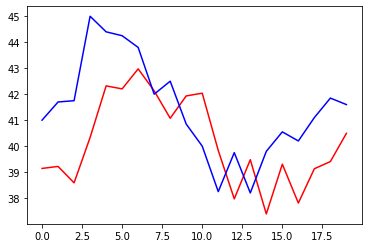

1.9000476455688475
       real    predict
0    [41.0]  39.141953
1    [41.7]  39.219509
2   [41.75]  38.586956
3    [45.0]  40.333748
4    [44.4]  42.319153
5   [44.25]  42.203796
6    [43.8]  42.974308
7    [42.0]  42.129372
8    [42.5]  41.072777
9   [40.85]  41.932800
10   [40.0]  42.038170
11  [38.25]  39.833370
12  [39.75]  37.971096
13   [38.2]  39.478107
14   [39.8]  37.391418
15  [40.55]  39.306042
16   [40.2]  37.810070
17   [41.1]  39.130672
18  [41.85]  39.407028
19   [41.6]  40.492340


In [ ]:
#————————————————預測模型————————————————————
def prediction():
    pred1,_=lstm(1,time_step,input_size)      #預測時只輸入[1,time_step,input_size]的測試資料
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #參數恢復
        module_file = tf.train.latest_checkpoint(r'./')
        saver.restore(sess, module_file)
        
        test_predict=[]
 
        #得到預測結果
        for i in range(len(test_X)):
            prob=sess.run(pred1,feed_dict={X:[test_X[i]]})
            predict=prob.reshape((-1))
            test_predict.extend(predict)
 
 
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='r')
        plt.plot(list(range(len(test_Y))), test_Y,  color='b')
        plt.show()
 
        acc = np.sum(np.abs(list(test_Y[i] - test_predict[i] for i in range(len(test_Y)))))/len(test_Y)
        print(acc)
 
 
        c = {"real" : test_Y,"predict" : test_predict}
        test = pd.DataFrame(c)
        #test=test.T
        print(test)
 
 
 
with tf.variable_scope('train',reuse=True):
    prediction()